## Import Libraries and load cifar10 dataset.

In [1]:
import torch
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
#import additional libraries if needed
from sklearn.model_selection import KFold

In [2]:
def load_cifar10_data(batch_size):
# load both training and test datasets, and transform them to tensors.
  transform = transforms.Compose([
          transforms.RandomCrop(32,padding=4),
          transforms.RandomHorizontalFlip(p=0.5),
          transforms.ToTensor(),
          transforms.Normalize((0.5), (0.5))
      ])

  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform)
  # splitting dataset into 80% as trainset and 20% as testset
  total_count = len(trainset)
  train_count = int(0.8 * total_count)
  test_count = total_count - train_count
  train_set, test_set = torch.utils.data.random_split(trainset, (train_count, test_count))
  trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

  testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  
  return trainloader, testloader

In [3]:
batch_size = 4
trainloader, testloader = load_cifar10_data(batch_size)
classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [4]:
# Check the dimensions of a batch:
for images, labels in trainloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([4, 3, 32, 32])
Image label dimensions: torch.Size([4])


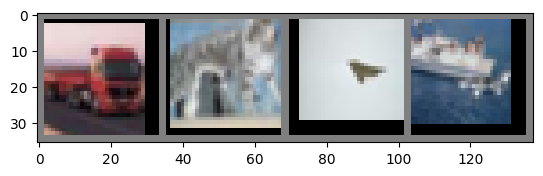

truck cat   plane ship 


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Section 1: Define your CNN model
Define your output layer, optimizer and loss criterion

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(32768,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,10),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x

In [7]:
#create model
model = CustomCNN()

## Section 2: Define optimizer and loss criterion

In [8]:
# Hyperparameters
random_seed = 153
learning_rate = 0.01
num_epochs = 10
num_folds = 10

save_to_location = './cifar_net.pt'

np.random.seed(random_seed)

kfold = KFold(n_splits=num_folds, random_state=random_seed, shuffle=True)

# optimizer
# optimizer = None
# loss
criterion = nn.CrossEntropyLoss()

In [9]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)
# Set my pretrained model to be run on GPU
# model = model.to(DEVICE)

Device: cuda:0


In [10]:
# Helper function to compute the accuracy
def compute_accuracy(model, testloader):
    correct, total_loss = 0, 0

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            pred = model(inputs)
            total_loss += criterion(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()
    
    total_loss /= len(testloader)
    correct /= len(testloader.dataset)
    print(f"For Current Run: Accuracy: {(100*correct):>0.1f}%, Avg loss: {total_loss:>8f}\n")
    return 100*correct

In [11]:
# Helper function to compute the loss over epochs
def compute_epoch_loss(model, trainloader, loss):
    for batch, data in enumerate(trainloader,0):
        # predictions  
        inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE) 
        pred = model(inputs)
        lf = criterion(pred, labels)
        
        # backprop
        loss.zero_grad()
        lf.backward()
        loss.step()

        if batch%100 == 0:
            lf, current = lf.item(), batch * len(inputs)
            print(f"Current loss: {lf:>7f}, [{current:>5d}/{len(trainloader.dataset):>5d}]")

In [12]:
def train_model(epoch_list, accuracy_list, num_epochs, trainloader, testloader, model, loss):
    for i in range(num_epochs):
        print(f"Epoch {i+1}")
        compute_epoch_loss(model, trainloader, loss)
        accuracy = compute_accuracy(model, testloader)
        epoch_list.append(i)
        accuracy_list.append(accuracy)

In [13]:
def perform_kfold_run():
    current_model = model
    current_model.to(DEVICE)
    for i, (train_indices, test_indices) in enumerate(kfold.split(trainloader.dataset)):
        print(f"Fold: {i+1}")
        train_sampler = torch.utils.data.Subset(trainloader.dataset, train_indices)
        test_sampler = torch.utils.data.Subset(trainloader.dataset, test_indices)
        train_loader = torch.utils.data.DataLoader(train_sampler, batch_size=45)
        test_loader = torch.utils.data.DataLoader(test_sampler, batch_size=45)
        
        epoch_list = []
        accuracy_list = []

        optimizer = torch.optim.SGD(current_model.parameters(), lr=learning_rate)
        train_model(epoch_list, accuracy_list, num_epochs, train_loader, test_loader, current_model, optimizer)

    torch.save(current_model.state_dict(), save_to_location)
    accuracy = compute_accuracy(current_model, testloader)
    print(accuracy)

In [14]:
perform_kfold_run()

Fold: 1
Epoch 1
Current loss: 2.296895, [    0/36000]
Current loss: 2.296609, [ 4500/36000]
Current loss: 2.310886, [ 9000/36000]
Current loss: 2.293799, [13500/36000]
Current loss: 2.258188, [18000/36000]
Current loss: 2.227406, [22500/36000]
Current loss: 2.154167, [27000/36000]
Current loss: 2.136643, [31500/36000]
For Current Run: Accuracy: 26.0%, Avg loss: 2.031031

Epoch 2
Current loss: 1.944736, [    0/36000]
Current loss: 1.869868, [ 4500/36000]
Current loss: 1.939103, [ 9000/36000]
Current loss: 1.952316, [13500/36000]
Current loss: 1.998132, [18000/36000]
Current loss: 1.958158, [22500/36000]
Current loss: 1.955171, [27000/36000]
Current loss: 1.914372, [31500/36000]
For Current Run: Accuracy: 31.2%, Avg loss: 1.890883

Epoch 3
Current loss: 1.850073, [    0/36000]
Current loss: 1.680496, [ 4500/36000]
Current loss: 1.819856, [ 9000/36000]
Current loss: 1.902409, [13500/36000]
Current loss: 1.799688, [18000/36000]
Current loss: 1.965434, [22500/36000]
Current loss: 1.817882, 

In [15]:
model = CustomCNN()
model.load_state_dict(torch.load(save_to_location))
model.eval()
model.to(DEVICE)
accuracy = compute_accuracy(model,testloader)
print(accuracy)

For Current Run: Accuracy: 76.6%, Avg loss: 0.896907

76.63


## Section 3: Test your model

In [16]:
dataiter = iter(testloader)
images, labels = next(dataiter)

In [17]:
#Test for the entire dataset

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(DEVICE), data[1].to(DEVICE)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 76 %
